In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q_Ah, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q_Ah

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q_Ah * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q_Ah, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q_Ah, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1

Train size ≃ 65.92%
Test  size ≃ 34.08%


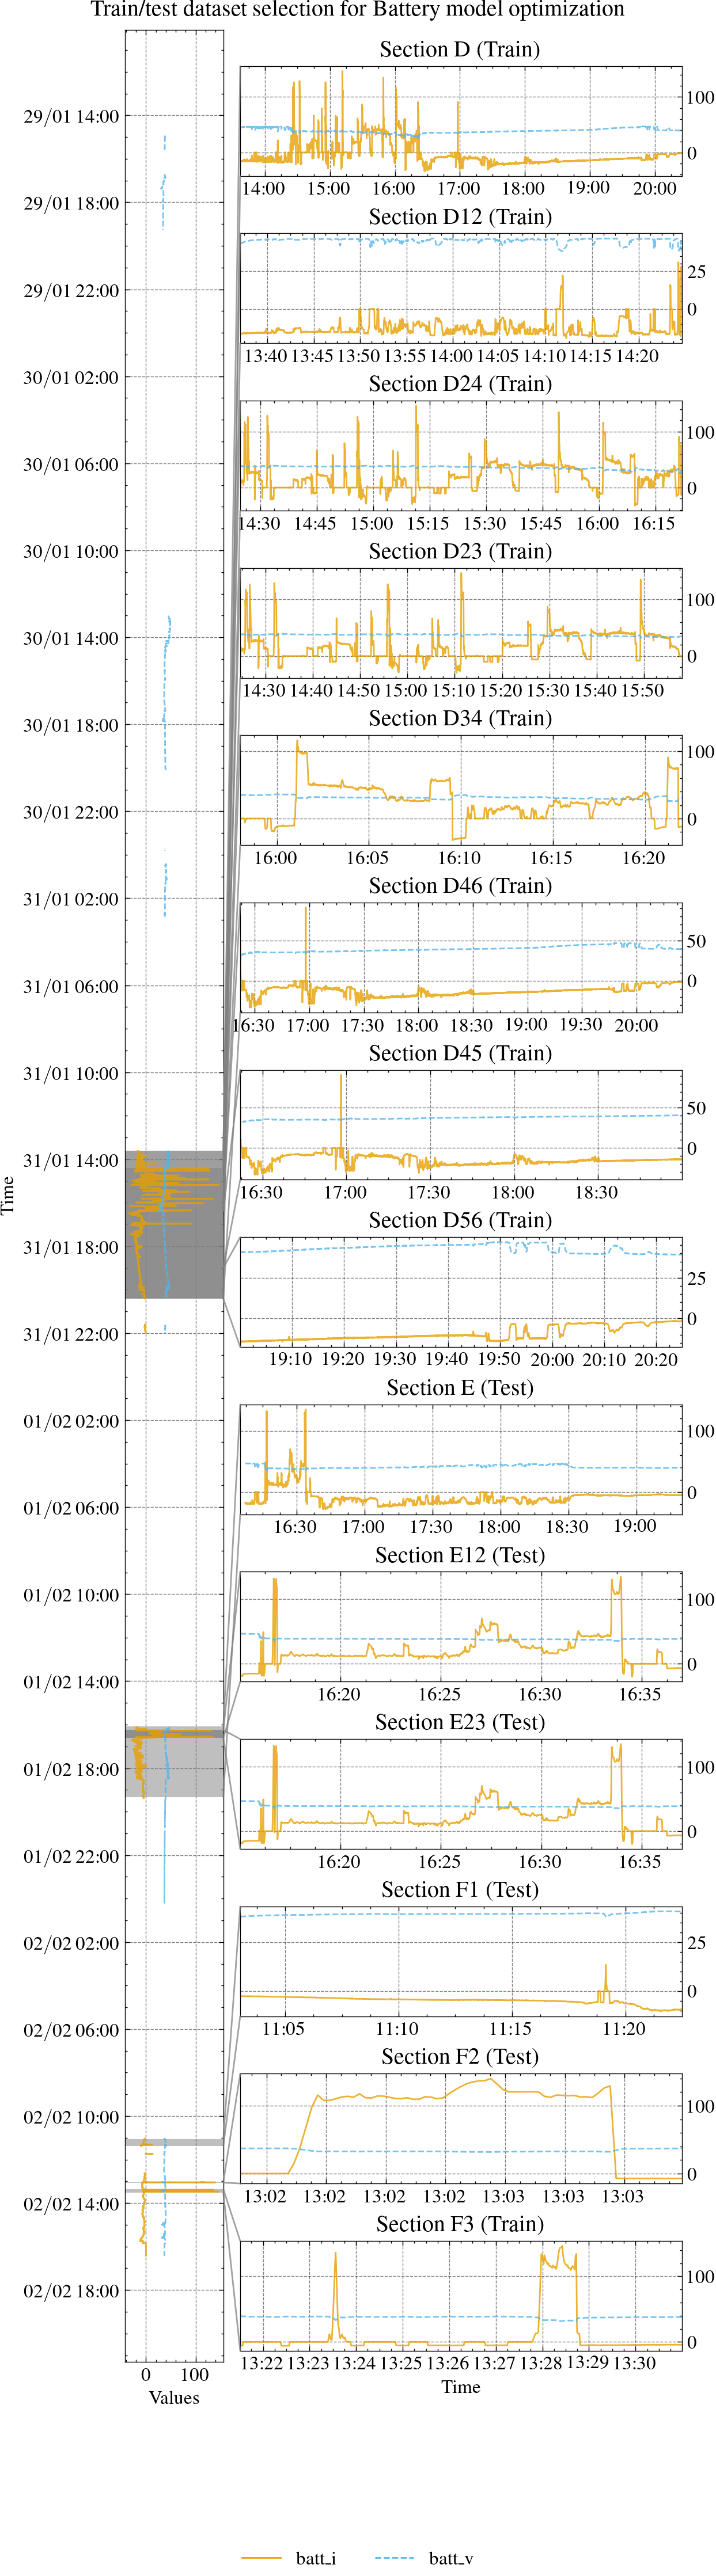

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q_Ah=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp('2020-01-31 13:37:04')  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp('2020-01-31 14:24:40')  # start of the race
D3 = pd.Timestamp('2020-01-31 15:58:00')  # battery enters in deep-discharge
D4 = pd.Timestamp('2020-01-31 16:22:00')  # race finishes, post-race charge starts
D5 = pd.Timestamp('2020-01-31 19:00:00')  # overcharge starts
D6 = pd.Timestamp('2020-01-31 20:24:55')  # end of the day
sections.loc['Section D'] = [D1, D6]  # Full race event
sections.loc['Section D12'] = [D1, D2]  # Full pre-race charge
sections.loc['Section D24'] = [D2, D4]  # Full race discharge
sections.loc['Section D23'] = [D2, D3]  # Race normal discharge range
sections.loc['Section D34'] = [D3, D4]  # Race deep-discharge range
sections.loc['Section D46'] = [D4, D6]  # Full post-race charge
sections.loc['Section D45'] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc['Section D56'] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 16:05:00'), pd.Timestamp('2020-02-01 19:20:00')] # A quick 15min discharge followed by an overcharge
sections.loc['Section E12'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # A ~15min discharge
sections.loc['Section E23'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # Another over-charging section
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 11:03:00'), pd.Timestamp('2020-02-02 11:22:30')] # A quick charge section
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:02:15'), pd.Timestamp('2020-02-02 13:03:30')] # 2min high-current pulse
sections.loc['Section F3'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:31:00')] # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section E', 'Section E12', 'Section E23', 'Section F1', 'Section F2', 'Section F3']]

train_sections_names = ['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section F3']

train_test_sections = sections.reset_index().to_dict(orient='records')
train_sections = sections.loc[sections.index.intersection(train_sections_names)].reset_index().to_dict(orient='records')
test_sections = sections.loc[sections.index.difference(train_sections_names)].reset_index().to_dict(orient='records')
all_sections = sections.reset_index().to_dict(orient='records')

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask  = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        sec['name'] = sec['name'] + ' (Train)'
        train_mask |= mask
    else:
        sec['name'] = sec['name'] + ' (Test)'
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test  size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
    filename=None,#'{latex_img_path}/battery_optimization_dataset.pdf',
    show_title=f'Train/test dataset selection for Battery model optimization',
    save_title=f'Dataset para treino do modelo da Bateria',
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=['batt_i', 'batt_v'],
        normalize=False,
    )
)

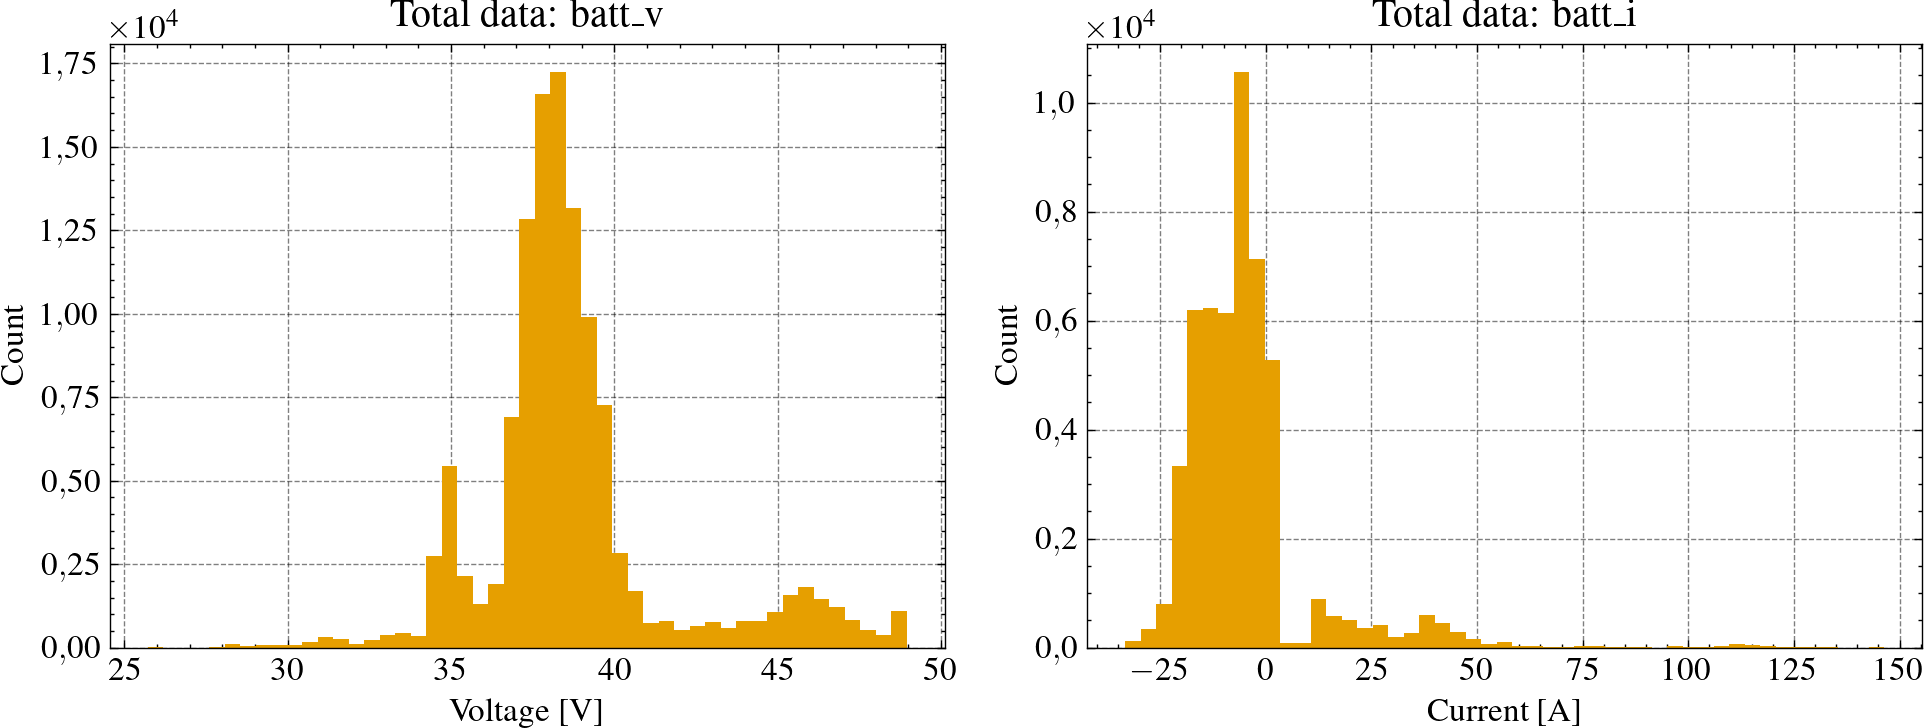

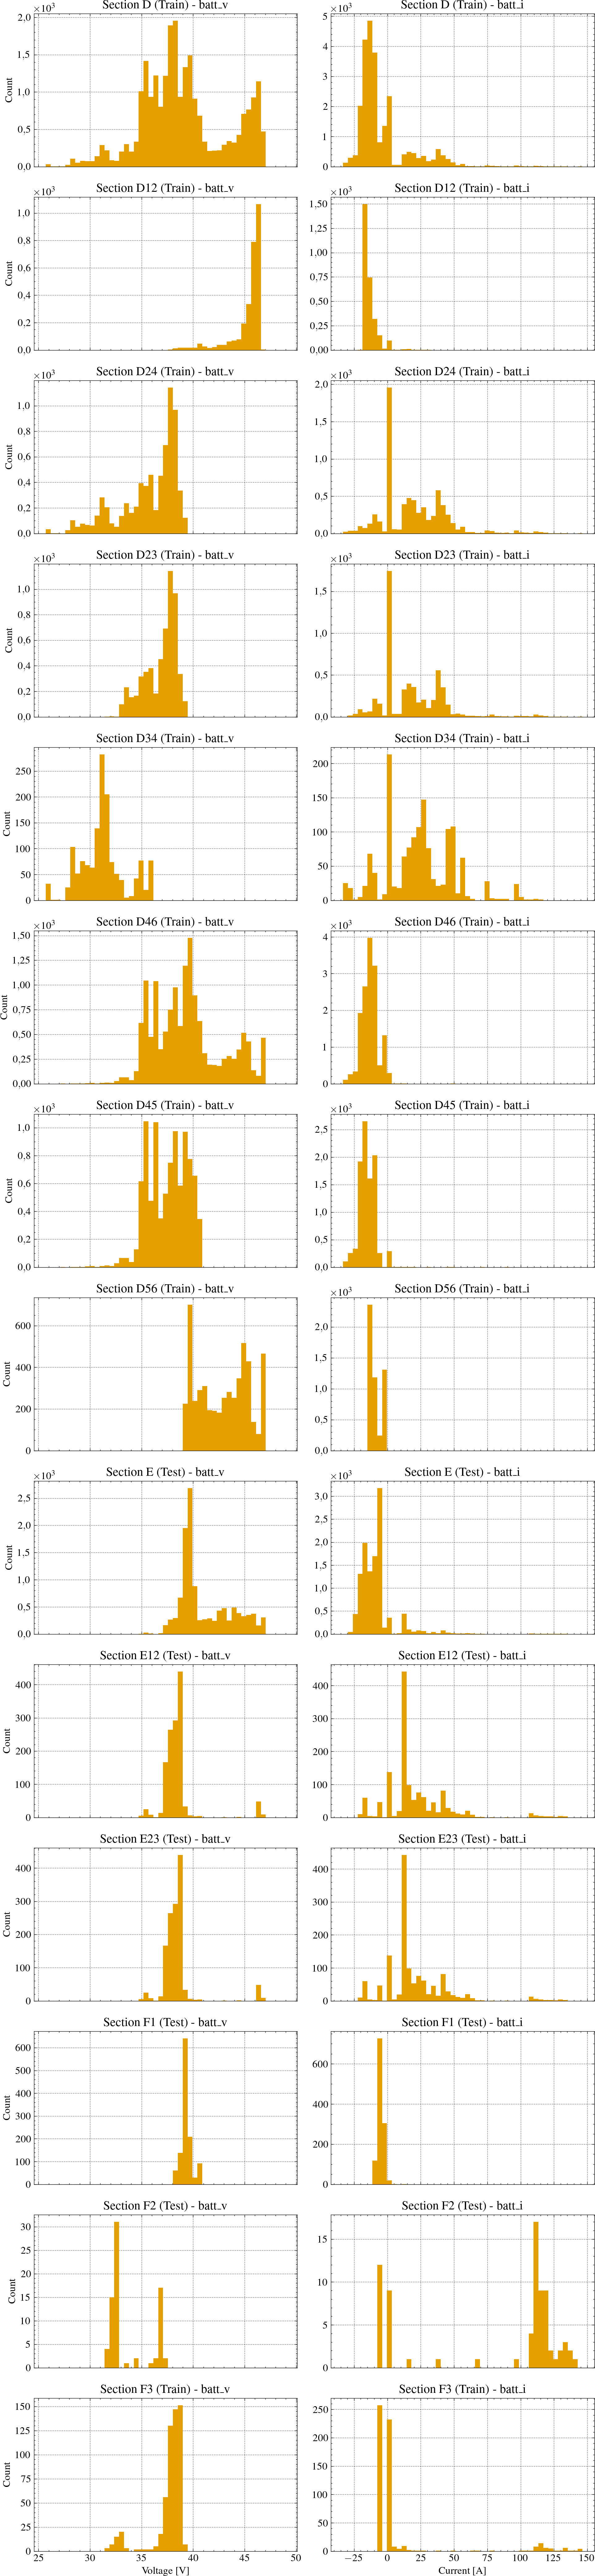

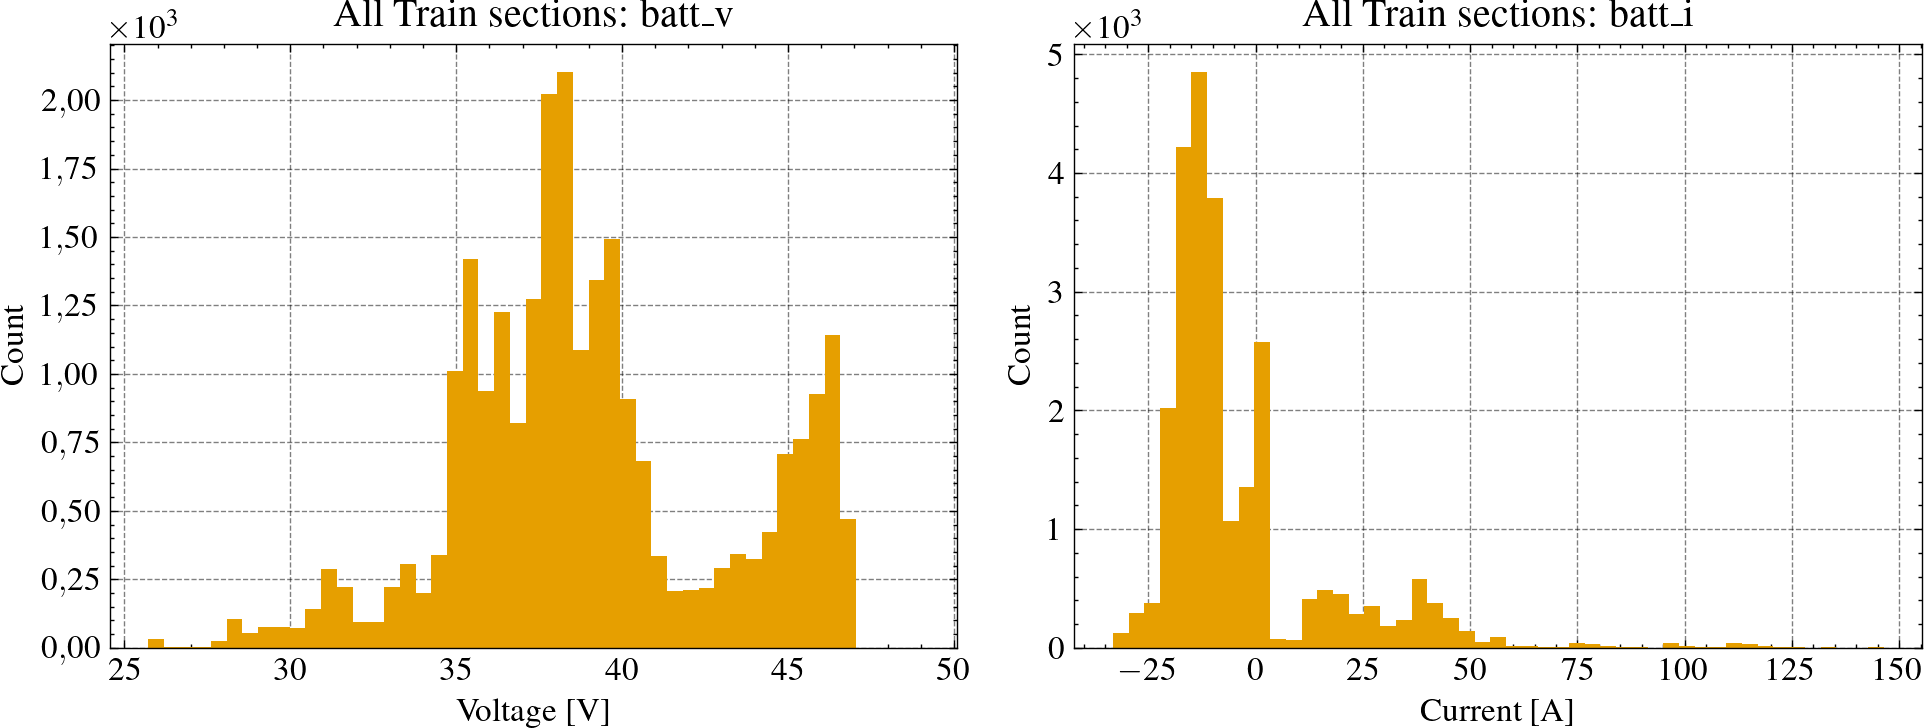

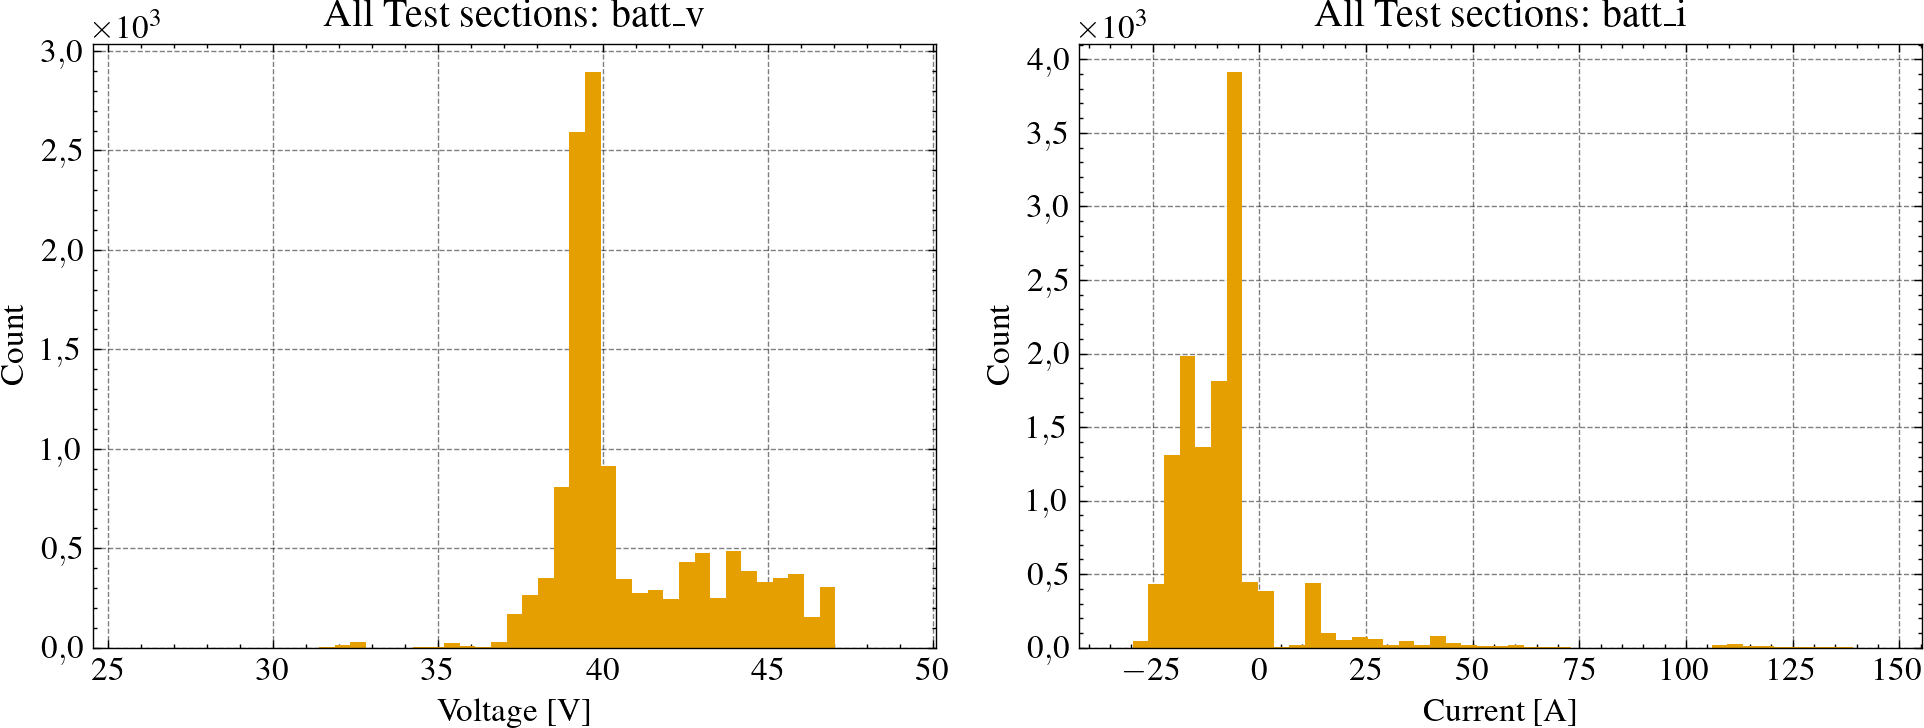

In [4]:
# Dataset Distributions

import numpy as np
import matplotlib.pyplot as plt

# Ensure we have a clean copy of sections with name/start/end
sections_df = sections.reset_index().rename(columns={'index': 'name'})

# Common bins for comparability
v_bins = np.linspace(df['batt_v'].min(), df['batt_v'].max(), 50)
i_bins = np.linspace(df['batt_i'].min(), df['batt_i'].max(), 50)

# ---------------------------------------------------------------------
# 1. Build union masks for train and test (no double-counting overlaps)
# ---------------------------------------------------------------------
train_mask = pd.Series(False, index=df.index)
test_mask = pd.Series(False, index=df.index)

for _, sec in sections_df.iterrows():
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        train_mask |= sec_mask
    else:
        test_mask |= sec_mask

# Optional sanity check: ensure no overlap between final train and test masks
overlap = train_mask & test_mask
if overlap.any():
    print("Warning: some timestamps are in both train and test masks.")

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

# ---------------------------------------------------------------------
# 2. Total dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('Total data: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('Total data: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Per-section histograms (each section, Train/Test split)
# ---------------------------------------------------------------------
n_sections = len(sections_df)
fig, axes = plt.subplots(n_sections, 2, figsize=(10, 3 * n_sections), sharex='col')

if n_sections == 1:
    axes = np.array([axes])  # make it 2D for consistency

for idx, (_, sec) in enumerate(sections_df.iterrows()):
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    dsec = df.loc[sec_mask]

    is_train = sec['name'] in train_sections_names
    label_prefix = 'Train' if is_train else 'Test'
    title = f"{sec['name']} ({label_prefix})"

    # Voltage
    ax_v = axes[idx, 0]
    ax_v.hist(dsec['batt_v'].dropna(), bins=v_bins)
    ax_v.set_title(f"{title} - batt_v")
    ax_v.set_ylabel('Count')
    if idx == n_sections - 1:
        ax_v.set_xlabel('Voltage [V]')

    # Current
    ax_i = axes[idx, 1]
    ax_i.hist(dsec['batt_i'].dropna(), bins=i_bins)
    ax_i.set_title(f"{title} - batt_i")
    if idx == n_sections - 1:
        ax_i.set_xlabel('Current [A]')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4. Aggregated Train dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_train['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Train sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_train['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Train sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5. Aggregated Test dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_test['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Test sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_test['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Test sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()


# Battery Equivalent Circuit Model


In [5]:
import numpy as np
import control as ct


def lut_interp(lut: np.array, x: float) -> float:
    """
    Linear interpolation over LUT vs. SoC z in [0, 1].

    lut[i] corresponds to z = i / (n-1).
    """
    n = len(lut)

    if n == 0:
        raise ValueError("LUT cannot be empty.")
    if n == 1:
        return lut[0]

    pos = x * (n - 1)
    lower_index = int(np.floor(pos))

    if lower_index >= n - 1:
        return lut[-1]
    if lower_index < 0:
        return lut[0]

    frac = pos - lower_index
    return lut[lower_index] * (1 - frac) + lut[lower_index + 1] * frac


class Battery:
    r"""
    AGM overcharge model using the Pb²⁺ concentration dynamics from the paper.

    Core equations (paper):
      - ċ = q - s
      - q = I_paper / (2 F)
      - s = 10 (c - c₀) V_PbSO4 D_hardening
      - D_hardening = (1 + k_hardening n_new) D_eff
      - n_new = ∫ q_new dt
      - E_Pb²⁺,pos = -(R T / (n F)) ln(c / c_s)
      - E_Pb²⁺,neg =  (R T / (n F)) ln(c / c_s)

    Here:
      - Input u[0] = batt_i  [A], POSITIVE = DISCHARGE, NEGATIVE = CHARGE
      - I_paper = -batt_i (sign convention of the article: I_paper > 0 = charge)
      - q_elec = I_paper / (2 F) = -batt_i / (2 F)

    Additional state (SoC) follows a standard Ah balance:
      - ż = - batt_i / batt_Q

    OCV model (per cell) from molality-based electrode potentials (paper):

      c_unit: state c is stored as [mol m⁻³]
              the OCV fit uses c_fit in [mol cm⁻³] = c / 1e6

      m = 1.00322e3 c_fit + 3.55e4 c_fit² + 2.17e6 c_fit³ + 2.06e8 c_fit⁴

      φ₀,+ =  1.628194
              + 0.073924 log₁₀ m
              + 0.033120 (log₁₀ m)²
              + 0.043220 (log₁₀ m)³
              + 0.021567 (log₁₀ m)⁴

      φ₀,− = -0.294600
              - 0.073595 log₁₀ m
              - 0.030531 (log₁₀ m)²
              - 0.030552 (log₁₀ m)³
              - 0.012045 (log₁₀ m)⁴

      batt_ocv_cell = φ₀,+ − φ₀,−

    Battery voltage output:

      - batt_ocv = batt_ocv_cell (single cell)
      - ΔV_over = E_Pb²⁺,pos - E_Pb²⁺,neg
      - batt_v (pack) = batt_N_S * (batt_ocv + ΔV_over)

    States:
      x[0] = batt_z   (SoC, unitless)
      x[1] = c        (Pb²⁺ ion concentration [mol m⁻³])
      x[2] = n_new    (density of not-hardened crystals [mol m⁻³])

    Input:
      u[0] = batt_i   (terminal current, A, + = discharge, - = charge)

    Outputs:
      y[0] = batt_z      (SoC)
      y[1] = batt_ocv    (OCV per cell [V])
      y[2] = batt_v      (pack terminal voltage [V])

    Parameters (all accessed with defaults via params.get):
      F               : Faraday constant [C mol⁻¹]
      R               : gas constant [J mol⁻¹ K⁻¹]
      T               : temperature [K]
      n               : valence Pb²⁺ (2)
      c_s             : equilibrium ion concentration [mol m⁻³]
      c_0             : reference concentration for s-term (≈ c_s)
      D_eff           : effective parameter including diffusion constant [s⁻¹]
      k_hardening     : linear scaling factor for “hardening crystals”
      tau_hardening   : time constant τ_hardening [s]
      V_PbSO4         : total PbSO₄ volume per unified volume [m³ m⁻³]
      batt_Q          : capacity [Coulomb] per cell
      batt_N_S        : number of series cells in the pack
    """

    # ------------------------------------------------------------------ #
    #  Molality-based OCV helpers                                        #
    # ------------------------------------------------------------------ #
    @staticmethod
    def _molality_from_concentration_cm3(c_mol_per_cm3: float) -> float:
        """
        Convert sulfuric acid concentration c [mol cm⁻³]
        to molality m [mol kg⁻¹] using the polynomial from the article:

          m = 1.00322e3 * c + 3.55e4 * c² + 2.17e6 * c³ + 2.06e8 * c⁴
        """
        c = c_mol_per_cm3
        return (
            1.00322e3 * c
            + 3.55e4   * c**2
            + 2.17e6   * c**3
            + 2.06e8   * c**4
        )

    @staticmethod
    def _phi0_pos_from_m(m: float) -> float:
        """
        Positive electrode equilibrium potential φ₀,+ [V] vs molality m [mol kg⁻¹]:

          φ₀,+ = 1.628194
                 + 0.073924 log₁₀ m
                 + 0.033120 (log₁₀ m)²
                 + 0.043220 (log₁₀ m)³
                 + 0.021567 (log₁₀ m)⁴
        """
        if m <= 0.0:
            raise ValueError("Molality m must be positive.")
        lg = np.log10(m)
        return (
            1.628194
            + 0.073924 * lg
            + 0.033120 * lg**2
            + 0.043220 * lg**3
            + 0.021567 * lg**4
        )

    @staticmethod
    def _phi0_neg_from_m(m: float) -> float:
        """
        Negative electrode equilibrium potential φ₀,− [V] vs molality m [mol kg⁻¹]:

          φ₀,− = -0.294600
                 - 0.073595 log₁₀ m
                 - 0.030531 (log₁₀ m)²
                 - 0.030552 (log₁₀ m)³
                 - 0.012045 (log₁₀ m)⁴
        """
        if m <= 0.0:
            raise ValueError("Molality m must be positive.")
        lg = np.log10(m)
        return (
            -0.294600
            - 0.073595 * lg
            - 0.030531 * lg**2
            - 0.030552 * lg**3
            - 0.012045 * lg**4
        )

    @classmethod
    def _ocv_cell_from_c(cls, c_mol_per_m3: float) -> float:
        """
        Cell OCV [V] as function of Pb²⁺ / electrolyte concentration c [mol m⁻³].

        The published polynomial uses c in [mol cm⁻³], so:

          c_fit = c_mol_per_m3 / 1e6
        """
        # convert from mol/m³ to mol/cm³
        c_cm3 = c_mol_per_m3 / 1e6
        if c_cm3 <= 0.0:
            # clip to a very small positive value to avoid log issues
            c_cm3 = 1e-12

        m = cls._molality_from_concentration_cm3(c_cm3)
        phi_pos = cls._phi0_pos_from_m(m)
        phi_neg = cls._phi0_neg_from_m(m)
        return phi_pos - phi_neg  # single-cell OCV [V]

    # ------------------------------------------------------------------ #
    #  Initial state                                                     #
    # ------------------------------------------------------------------ #
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        """
        X0 keys:
          'batt_z' : initial SoC
          'c'      : initial Pb²⁺ concentration [mol m⁻³]
          'n_new'  : initial not-hardened crystal density [mol m⁻³] (optional)

        U0:
          initial input vector (unused except for shape consistency).
        """
        batt_z0 = float(X0["batt_z"])
        c0 = float(X0["c"])
        n_new0 = float(X0.get("n_new", 0.0))
        return np.array([batt_z0, c0, n_new0], dtype=float)

    # ------------------------------------------------------------------ #
    #  State update                                                      #
    # ------------------------------------------------------------------ #
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # States
        batt_z = float(x[0])
        c = float(x[1])
        n_new = float(x[2])

        # Input: POSITIVE = DISCHARGE, NEGATIVE = CHARGE
        batt_i = float(u[0])

        # Embedded constants with defaults
        F = params.get("F", 96485.34)
        D_eff = params.get("D_eff", 1.0)              # [s⁻¹], must be calibrated
        V_PbSO4 = params.get("V_PbSO4", 1.0)          # [m³ m⁻³], from SOC/K
        c0 = params.get("c_0", params.get("c_s", 1.0))
        k_hard = params.get("k_hardening", 0.0)
        tau_hard = params.get("tau_hardening", 3600.0)
        batt_Q = params.get("batt_Q", 3600.0)         # [C], 1 Ah default

        # Paper current convention: I_paper > 0 = CHARGE
        I_paper = -batt_i

        # Electrochemical Pb²⁺ rate:
        #   q = I_paper / (2F)
        q_elec = I_paper / (2.0 * F)

        # Hardening-modified effective parameter:
        #   D_hardening = (1 + k_hardening n_new) D_eff
        D_hardening = (1.0 + k_hard * n_new) * D_eff

        # Chemical dissolution/crystallization rate:
        #   s = 10 (c - c₀) V_PbSO4 D_hardening
        s_chem = 10.0 * (c - c0) * V_PbSO4 * D_hardening

        # Concentration ODE:
        #   ċ = q - s
        c_dot = q_elec - s_chem

        # n_new ODE (RC interpretation) [ASSUMPTION]:
        #   q_new = q_elec - q_hardening
        #   q_hardening = n_new / τ_hardening
        #   ṅ_new = q_new
        n_new_dot = q_elec - n_new / tau_hard

        # SoC ODE (Ah balance, efficiencies = 1):
        #   batt_ż = - batt_i / batt_Q
        batt_z_dot = -batt_i / batt_Q

        return np.array([batt_z_dot, c_dot, n_new_dot])

    # ------------------------------------------------------------------ #
    #  Outputs: SoC, OCV, terminal voltage                               #
    # ------------------------------------------------------------------ #
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        batt_z = float(x[0])
        c = float(x[1])
        # n_new = float(x[2])  # not used in outputs

        # Embedded constants
        F = params.get("F", 96485.34)
        R = params.get("R", 8.314472)
        T = params.get("T", 298.15)
        n = params.get("n", 2.0)
        c_s = params.get("c_s", 1.0)
        batt_N_S = params.get("batt_N_S", 1)

        # OCV per cell from molality-based model, using state c
        batt_ocv = cls._ocv_cell_from_c(c)

        # Overvoltages from the paper:
        #   E_Pb²⁺,pos = -(RT / nF) ln(c / c_s)
        #   E_Pb²⁺,neg =  (RT / nF) ln(c / c_s)
        c_clamped = max(c, 1e-30)
        ratio = c_clamped / c_s
        ln_ratio = np.log(ratio)

        E_Pb2_pos = -(R * T / (n * F)) * ln_ratio
        E_Pb2_neg =  (R * T / (n * F)) * ln_ratio

        # Pack voltage:
        #   batt_v = batt_N_S * (batt_ocv + E_Pb2_pos - E_Pb2_neg)
        batt_v = batt_N_S * (batt_ocv + (E_Pb2_pos - E_Pb2_neg))

        return np.array([batt_z, batt_ocv, batt_v])

    # ------------------------------------------------------------------ #
    #  Build NonlinearIOSystem                                           #
    # ------------------------------------------------------------------ #
    @classmethod
    def build(cls, params: dict):
        """
        Returns a control.NonlinearIOSystem with:

          states  = ("batt_z", "c", "n_new")
          inputs  = ("batt_i",)
          outputs = ("batt_z", "batt_ocv", "batt_v")
        """
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name="battery",
            states=("batt_z", "c", "n_new"),
            inputs=("batt_i",),
            outputs=("batt_z", "batt_ocv", "batt_v"),
            params=params,
        )


# Example construction (parameters must be supplied by caller)
Battery.build({})


<NonlinearIOSystem battery: ['batt_i'] -> ['batt_z', 'batt_ocv', 'batt_v']>

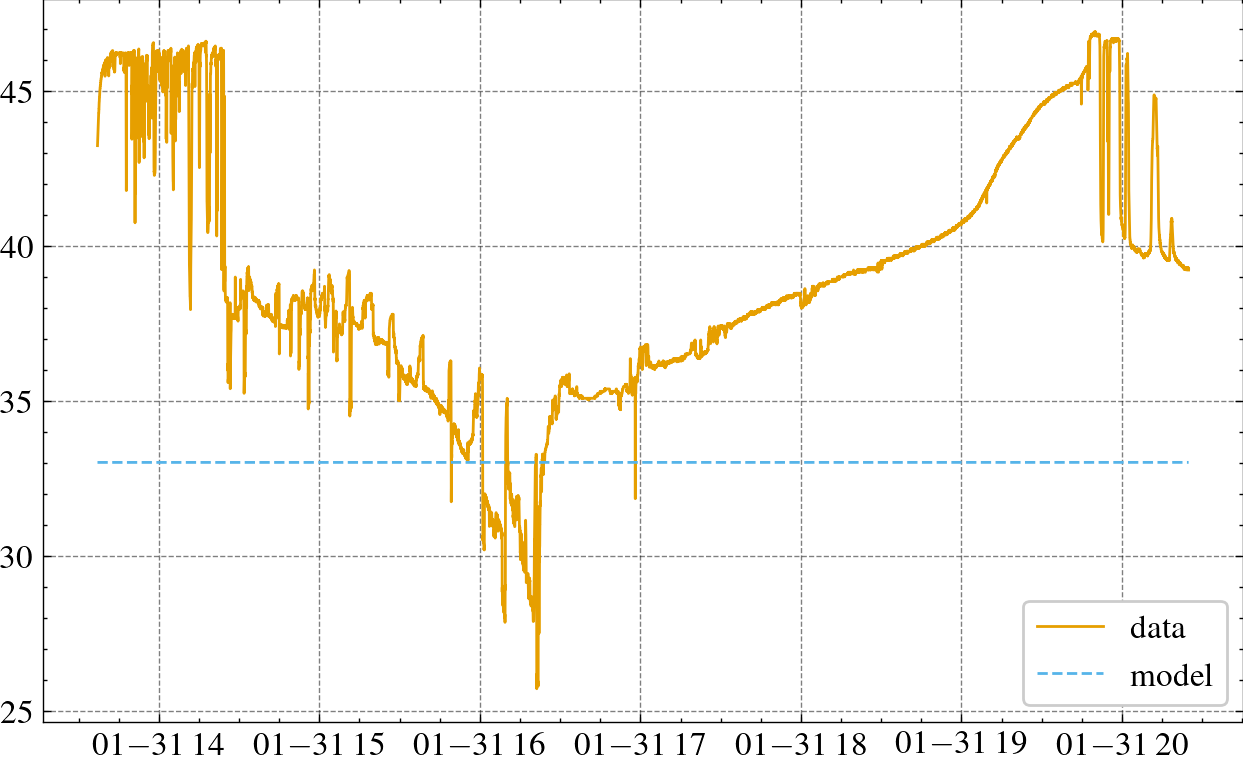

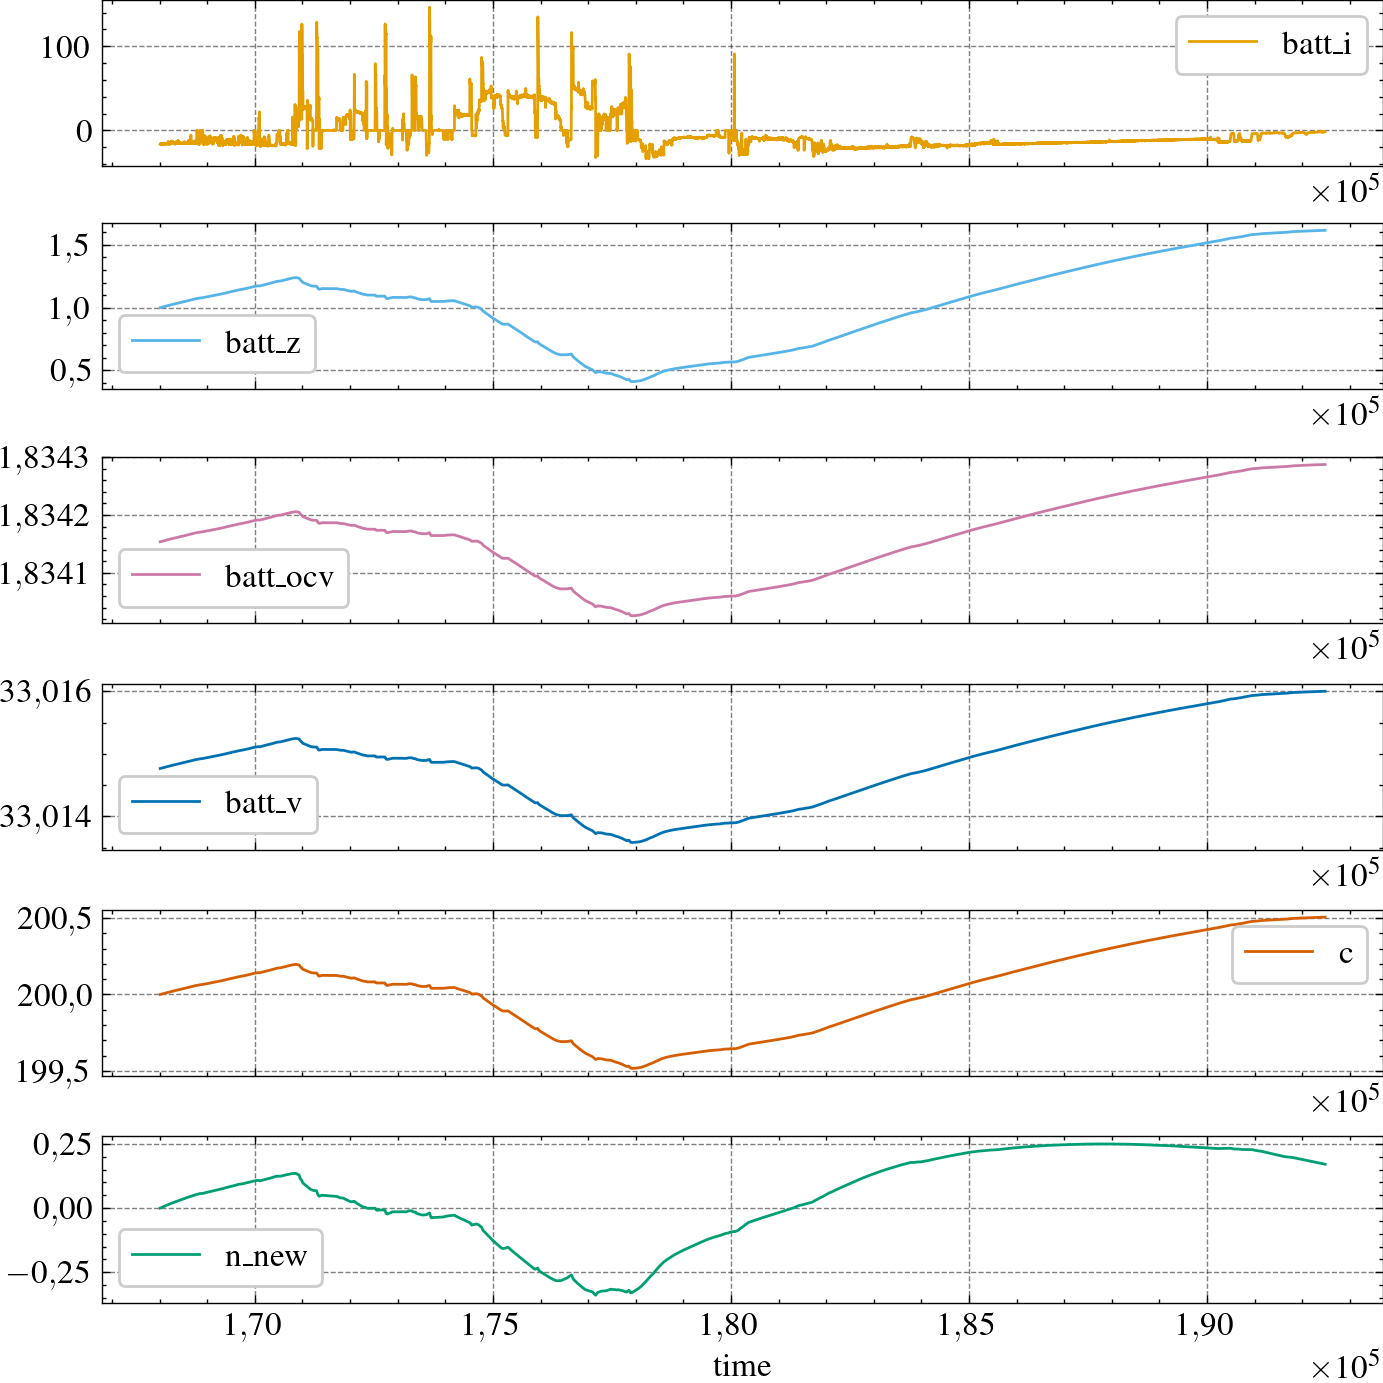

In [17]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q_Ah = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
batt_Q = nominal_Q_Ah * 3600 # [Ah] -> [As]
nominal_voltage = series_cells * cell_voltage
batt_ocv_lut = np.array([10.7865, 10.9583, 11.1160, 11.2607, 11.3937, 11.5161, 11.6292, 11.7343, 11.8324, 11.9249, 12.0129, 12.0976, 12.1803, 12.2622, 12.3444, 12.4283, 12.5150, 12.6056, 12.7016, 12.8039, 12.9139], dtype=float)
initial_SOC = 1

battery_params = dict(
    # ------------------------------------------------------------
    # Physical constants (not tuned)
    # ------------------------------------------------------------
    F = 96485.34,          # C/mol
    R = 8.314472,          # J/(mol·K)
    T = 298.15,            # K (≈25 °C, as in the papers)
    n = 2.0,               # Pb²⁺ valence

    # ------------------------------------------------------------
    # Battery configuration: ONE 12 V BLOCK (Optima 44 Ah)
    # ------------------------------------------------------------
    # 44 Ah → 44 * 3600 = 158400 C per 12 V block
    batt_Q = 44.0 * 3600.0,   # 158400 C per 12 V block

    # Internal series cells inside the 12 V block
    batt_N_S = 3*6,             # 6 × ~2 V cells in series → ~12 V

    # ------------------------------------------------------------
    # Pb²⁺ ion concentration model
    # ------------------------------------------------------------
    # Pb²⁺ equilibrium conc. (10⁻⁶–10⁻³ mol/cm³ → 1–1000 mol/m³, mid-range chosen)
    c_s  = 200.0,          # mol/m³
    c_0  = 200.0,          # mol/m³, = c_s (per ramp model)

    # PbSO₄ volume fraction; at full SoC (z=1) → 0
    V_PbSO4 = 0.0,         # m³ PbSO₄ per m³ active volume

    # ------------------------------------------------------------
    # Overcharge / crystal-dissolution dynamics (Thele 2006)
    # ------------------------------------------------------------
    # D_eff in 10⁻⁶–10⁻⁴ s⁻¹ → choose mid-range
    D_eff = 3e-5,          # s⁻¹

    # Hardening factor (dimensionless, moderate effect)
    k_hardening = 0.1,

    # Hardening time constant (crystal “aging” in ~1 h)
    tau_hardening = 3600.0,  # s

    # ------------------------------------------------------------
    # Gassing / recombination (optional, if you add that submodel)
    # ------------------------------------------------------------
    # Exchange currents, consistent with VRLA spiral-wound behaviour
    i0_O2 = 1e-8,          # A
    i0_H2 = 1e-12,         # A

    # Tafel slopes (positive: ~110 mV/dec, negative: small)
    taf_pos = 0.11,        # V/dec
    taf_neg = 0.02,        # V/dec

    # ------------------------------------------------------------
    # Nominal initial states (used to build X0)
    # ------------------------------------------------------------
    batt_z = 1.0,     # fully charged block
    c      = 200.0,   # mol/m³ (equilibrium at full charge)
    n_new  = 0.0,     # no fresh sulfate crystals at z=1
)

if True:
    # Select the optimization data
    data_cols = ['batt_v']
    input_cols = ['batt_i']
    train_section = train_sections[0]

    df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]#[:7000]

    # Time array
    T = np.ascontiguousarray(df_train['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

    # Model
    battery = Battery.build(battery_params)

    # Initial state
    X0 = Battery.initial_state(
        X0=dict(
            batt_z = initial_SOC,
            c      = battery_params.get("c_s", 1.0),
            n_new  = 0.0,
        ),
        U0=U[:,0],
        params=battery_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau', solve_ivp_kwargs=dict(max_step=1))
    ydata = res.to_pandas().set_index('time')#[sorted(list(set(res.output_labels + res.state_labels)))]

    plt.figure()
    plt.plot(df_train.index, df_train['batt_v'], label='data')
    plt.plot(df_train.index, ydata['batt_v'], label='model')
    plt.legend(loc='lower right')
    plt.show()

    ydata.plot(subplots=True, figsize=(7,7))
    plt.show()

# Train dataset SOC estimation

In [18]:
def evaluate_soc(df, batt_Q: float,initial_SOC: float, section_name: str, section_decription: str="") -> pd.DataFrame:
    section = next(s for s in all_sections if s['name'] == section_name)
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_section, batt_Q/3600, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q/3600, inplace=True)
    # df_section['batt_z'] = np.clip(df_section['batt_z'], 0, 1)
    
    ending_SOC = float(df_section['batt_z'].iloc[-1])

    print(f'Section {section_name}: SOC went from {initial_SOC} to {ending_SOC}')

    return df_section


In [19]:
# initial_SOC = 1.0
# batt_Q = nominal_Q_Ah * 3600
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# initial_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D1],
#     'Section D12': df_section['batt_z'].loc[D1],
#     'Section D24': df_section['batt_z'].loc[D2],
#     'Section D23': df_section['batt_z'].loc[D2],
#     'Section D34': df_section['batt_z'].loc[D3],
#     'Section D46': df_section['batt_z'].loc[D4],
#     'Section D45': df_section['batt_z'].loc[D4],
#     'Section D56': df_section['batt_z'].loc[D5],
# }
# ending_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D12': df_section['batt_z'].loc[D2],
#     'Section D24': df_section['batt_z'].loc[D4],
#     'Section D23': df_section['batt_z'].loc[D3],
#     'Section D34': df_section['batt_z'].loc[D4],
#     'Section D46': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D45': df_section['batt_z'].loc[D5],
#     'Section D56': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
# }
# display('initial_SOC_dict:', initial_SOC_dict)
# display('ending_SOC_dict:', ending_SOC_dict)

In [20]:
# # TODO: idea: fit Q on full D, 

# # Cleaned params for our sectorized optimization strategy
# initial_params = dict(
#     # Capacity / efficiencies
#     batt_Q      = batt_Q,  # 172800 C per 12 V block
# )

# initial_SOC = 1.0
# batt_Q = 1.0
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# df_section['batt_z'] -= df_section['batt_z'].min()

# df_section[['batt_v', 'batt_z', 'batt_i']].plot(subplots=True, figsize=(7,3))
# plt.show()

# # section_df.loc[D6 - pd.Timedelta('1s')]

# Optimization

In [21]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

# Constraints
from dataclasses import dataclass
from typing import Literal
import numpy as np

ConstraintKind = Literal[
    "simple_order",
    "simple_gap",
    "deep_extra",
    "beta_z_min",
    "beta_z_max",
    "smoothness",
]

@dataclass
class ParamConstraint:
    """
    Generic constraint usable by pymoo: g(x) <= 0 when satisfied.
    Picklable, works with multiprocessing.
    """
    kind: ConstraintKind

    # indices into the decision vector x
    idx_a: int | None = None
    idx_b: int | None = None
    idx_c: int | None = None  # third index if needed (e.g. z_deep)

    # generic scalars for constraints
    gap: float = 1.0          # used by simple_gap
    limit: float = 0.0        # used by deep_extra, beta_z_min/max

    def __call__(self, x: np.ndarray) -> float:
        if self.kind == "simple_gap":
            # tau_b >= gap * tau_a -> gap*tau_a - tau_b <= 0
            return self.gap * x[self.idx_a] - x[self.idx_b]

        if self.kind == "simple_order":
            # R_a < R_b -> R_a - R_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "deep_extra":
            # deep-discharge extra "ohms" at z ~ 0:
            #   R_extra = R0_deep + k_deep * max(0, z_deep)
            # constraint: R_extra <= limit  -> R_extra - limit <= 0
            R0_deep = x[self.idx_a]
            k_deep  = x[self.idx_b]
            z_deep  = x[self.idx_c]
            R_extra = R0_deep + k_deep * max(0.0, z_deep)
            return R_extra - self.limit

        if self.kind == "beta_z_min":
            # beta * z_deep >= limit  -> limit - beta*z <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return self.limit - beta * z_deep

        if self.kind == "beta_z_max":
            # beta * z_deep <= limit  -> beta*z - limit <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return beta * z_deep - self.limit
        
        if self.kind == "smoothness":
            return abs(x[self.idx_a] - 2*x[self.idx_b] + x[self.idx_c]) - self.limit

        return 0.0

class BatteryWithSocOptimizationProblem(ElementwiseProblem):
    def __init__(
        self,
        model,
        model_function,
        training_data,
        training_data_columns,
        model_params,
        opt_params_bounds,
        input_columns,
        data_scaler=RobustScaler,
        constraint_funcs=None,
        print_exceptions=False,
        **kwargs,
    ):
        assert all(
            "min" in pb and "max" in pb for pb in opt_params_bounds.values()
        ), "All opt_params_bounds must have 'min' and 'max' keys"

        self.model = model
        self.model_function = model_function
        self.model_params = model_params
        self.data_scaler_cls = data_scaler
        self.training_data_columns = training_data_columns  # e.g. ['batt_v', 'batt_z']
        self.opt_param_names = list(opt_params_bounds.keys())
        self.input_columns = input_columns
        self.print_exceptions = print_exceptions
        self.constraint_funcs = constraint_funcs or []

        # Keep the raw training data (no batt_z yet)
        self.training_data_raw = training_data.copy(deep=True)

        # Time vector
        self.T = np.ascontiguousarray(training_data['t'].to_numpy())

        # Inputs
        self.U = np.ascontiguousarray(training_data[input_columns].to_numpy().T)

        # --- Fit scaler once using a baseline initial_SOC0 (e.g. 0.5) ---
        df0 = self.training_data_raw.copy()
        initial_SOC0 = 0.5
        batt_Q_Ah = self.model_params['batt_Q'] / 3600
        compute_df_capacity(df0, batt_Q_Ah, initial_SOC0, inplace=True)
        compute_df_soc(df0, batt_Q_Ah, inplace=True)
        Y0 = df0[self.training_data_columns].to_numpy()
        self.data_scaler = self.data_scaler_cls().fit(Y0)

        super().__init__(
            n_var=len(self.opt_param_names),
            n_obj=1,
            n_constr=len(self.constraint_funcs),
            xl=np.array([p["min"] for p in opt_params_bounds.values()]),
            xu=np.array([p["max"] for p in opt_params_bounds.values()]),
            **kwargs,
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.objective_function(x, *args, **kwargs)

        if self.constraint_funcs:
            # Each constraint func should return a scalar ≤ 0 when satisfied
            g = [func(x) for func in self.constraint_funcs]
            out["G"] = np.array(g)

    def objective_function(self, x, *args, **kwargs):
        # Map decision vector to parameters
        params_dict = {name: x[i] for i, name in enumerate(self.opt_param_names)}
        initial_SOC = params_dict.pop('batt_z')
        model_params = self.model_params | convert_to_model_params(params_dict)
        batt_Q_Ah = model_params['batt_Q'] / 3600

        # Recompute SOC trajectory from candidate batt_z_0
        df_temp = self.training_data_raw.copy()
        compute_df_capacity(df_temp, batt_Q_Ah, initial_SOC, inplace=True)
        compute_df_soc(df_temp, batt_Q_Ah, inplace=True)

        # Ground truth (voltage + SOC) for this candidate
        y_true = df_temp[self.training_data_columns].to_numpy()
        scaled_y_true = self.scale_data(y_true)

        # Initial state
        X0 = self.model.initial_state(
            X0=dict(
                batt_z = df_temp['batt_z'].iloc[0],
                c      = model_params["c"],
                n_new  = model_params["n_new"],
            ),
            U0=self.U[:, 0],
            params=model_params,
        )

        # Run the simulation
        try:
            model_predictions = self.model_function(
                T=self.T, U=self.U, X0=X0, **model_params
            )[self.training_data_columns].to_numpy()
        except Exception as e:
            if self.print_exceptions:
                print(f"Exception from model_function: {e}")
            return 1e9  # Penalize parameters that break the model

        # Scale model predictions
        scaled_model_predictions = self.scale_data(model_predictions)

        return mean_squared_error(scaled_y_true, scaled_model_predictions)

    def scale_data(self, data):
        return self.data_scaler.transform(data)

    def rescale_data(self, data):
        return self.data_scaler.inverse_transform(data)

def run_battery_optimization(
    model,
    model_params: dict,
    section_name: str,
    params_bounds: dict,
    initial_SOC: float,
    df,
    constraint_funcs: list,
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=20,
):
    train_section = next(s for s in train_sections if s['name'] == section_name)
    print(''.join(['=']*100))
    print('\n\nTraining on section:', section_name)

    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

        # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')

    lut_coeffs = [
        # {'name': 'batt_ocv_lut', 'lut_size': 21, 'bounds': (10.5, 13.5)},
    ]
    for coeff in lut_coeffs:
        name = coeff['name']
        values_bounds = coeff['bounds']
        lut_size = coeff['lut_size']
        for i in range(0, lut_size):
            params_bounds[f'{name}_{i}'] = dict(min=values_bounds[0], max=values_bounds[1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    try:
        # Set up the optimization problem
        if 'batt_z' in params_bounds:
            problem = BatteryWithSocOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )
        else:
            # Compute battery capacity and SOC using the hyperparameter initial_SOC
            batt_Q_Ah = model_params['batt_Q'] / 3600
            compute_df_capacity(df_train, batt_Q_Ah, initial_SOC, inplace=True)
            compute_df_soc(df_train, batt_Q_Ah, inplace=True)

            # Initial state
            input_initial_state = dict(
                batt_z=df_train['batt_z'].iloc[0],
                batt_v=df_train['batt_v'].iloc[0],
            )

            problem = MyOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_initial_state=input_initial_state,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )

        # Configure the optimization algorithm (Differential Evolution in this case)
        algorithm = DE(
            pop_size=algorithm_pop_size_k * len(params_bounds),
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )
        # algorithm = CMAES(
        #     pop_size=32,     # 16–64 is typical
        #     sigma=0.3        # initial step size in normalized space
        # )

        # Set termination criteria
        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=termination_period,
            n_max_gen=10000,
            n_max_evals=1000000,
        )

        # Run the optimization
        result = minimize(
            problem,
            algorithm,
            termination=termination,
            seed=42,
            verbose=True,
            save_history=True,
        )
    finally:
        pool.close()
        pool.join()

    # Retrieve and display the best parameters
    raw_params = {k: result.X[i] for i, k in enumerate(params_bounds.keys())}
    best_params = convert_to_model_params(raw_params)
    original_params = {k: convert_to_model_params(model_params).get(k) for k in best_params.keys()}
    print("Original parameters were:")
    display(original_params)
    print("Best parameters found:")
    display(best_params)
    print("Objective value at solution:", result.F)

    # Plot optimization results
    if plot_results:
        plot_optimization_params(result, params_bounds)
        plot_optimization_error(result)

    initial_SOC_opt = best_params.get("batt_z", initial_SOC)
    batt_Q_Ah  = (model_params | best_params)['batt_Q'] / 3600

    # Simulate the model with the optimized parameters
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_train, batt_Q_Ah, initial_SOC_opt, inplace=True)
    compute_df_soc(df_train, batt_Q_Ah, inplace=True)
    T = np.ascontiguousarray(df_train['t'].to_numpy())
    U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
    X0 = model.initial_state(
            X0=dict(
                batt_z = df_train['batt_z'].iloc[0],
                c      = model_params["c"],
                n_new  = model_params["n_new"],
            ),
            U0=U[:, 0],
            params=model_params,
        )
    best_fit_data = model_function(T, U, X0, **(model_params | best_params))
    ending_SOC = best_fit_data['batt_z'].iloc[-1]

    if plot_simulation:
        # Plot the comparison for each data column
        for col in data_cols:
            plot_compare(df_train, best_fit_data, col)

    return result, params_bounds, best_params, ending_SOC

def check_fit(section_name, model_params, initial_SOC):
    batt_Q_Ah = model_params['batt_Q'] / 3600
    section = next(s for s in all_sections if s['name'] == section_name)

    data_cols = ['batt_v']
    input_cols = ['batt_i']
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols]
    compute_df_capacity(df_section, batt_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q_Ah, inplace=True)

    # Time array
    T = np.ascontiguousarray(df_section['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_section[input_cols].to_numpy().T)

    # Model
    battery = Battery.build(model_params)

    # Initial state
    X0 = Battery.initial_state(
        X0={
            'batt_z': initial_SOC,
            'batt_v': df_section['batt_v'].iloc[0],
        },
        U0=U[:,0],
        params=model_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
    ydata = res.to_pandas().set_index('time')[sorted(data_cols)]

    for column in ydata.columns:
        plot_compare(df_section, ydata, column, show=True)

In [22]:
# Cleaned params for our sectorized optimization strategy
initial_params = dict(
    # ------------------------------------------------------------
    # Physical constants (not tuned)
    # ------------------------------------------------------------
    F = 96485.34,          # C/mol
    R = 8.314472,          # J/(mol·K)
    T = 298.15,            # K (paper measurements ~25 °C)
    n = 2.0,               # Pb²⁺ valence

    # ------------------------------------------------------------
    # Battery configuration
    # ------------------------------------------------------------
    batt_N_S = 3*6,          # 12-V battery = 6 cells in series

    # Per-cell capacity:
    # 44 Ah battery → ~7.33 Ah per cell → 26400 C per cell
    batt_Q = 26400.0,      # Coulombs per cell

    # ------------------------------------------------------------
    # Pb²⁺ ion concentration model
    # ------------------------------------------------------------
    # Pb²⁺ equilibrium concentration c_s (paper solubility range 10⁻⁶–10⁻³ mol/cm³)
    # Convert to mol/m³ by ×1e6 → choose midrange ~200 mol/m³
    c_s  = 200.0,          # mol/m³         [ASSUMPTION mid-range]
    c_0  = 200.0,          # mol/m³, = c_s  (per paper)

    # Effective PbSO₄ volume fraction, SOC=1 → 0
    V_PbSO4 = 0.0,         # dimensionless  (fully charged state)

    # ------------------------------------------------------------
    # Overcharge / crystal-dissolution dynamics (Thele 2006)
    # ------------------------------------------------------------
    # D_eff is ~1e-6…1e-4 s⁻¹ → choose geometric midrange ~3e-5 s⁻¹
    D_eff = 3e-5,          # s⁻¹            [mid-range of paper values]

    # Hardening acceleration factor (0–1 range)
    k_hardening = 0.1,     # dimensionless  [ASSUMPTION: modest effect]

    # Hardening time constant τ, minutes–hours → choose 3600 s = 1 hour
    tau_hardening = 3600.0,  # s            [paper uses hour-scale]

    # ------------------------------------------------------------
    # Gassing / recombination (if used)
    # ------------------------------------------------------------
    # Exchange currents: extremely small for VRLA spiral-wound
    i0_O2 = 1e-8,          # A    [within published 1e-9–1e-7 range]
    i0_H2 = 1e-12,         # A    [hydrogen suppressed]

    # Tafel slopes (paper: +110 mV/dec, negative ~0–small)
    taf_pos = 0.11,        # V/dec
    taf_neg = 0.02,        # V/dec

    # ------------------------------------------------------------
    # Initial states (converted separately, but giving nominal values)
    # ------------------------------------------------------------
    batt_z = 1.0,     # Initial SoC
    c      = 200.0,   # mol/m³ (at equilibrium at full charge)
    n_new  = 0.0,     # no new crystals at full charge
)




Training on section: Section D
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      140 |  1.000000E+09 |  1.000000E+09
     2 |      280 |  1.000000E+09 |  1.000000E+09
     3 |      420 |  1.000000E+09 |  1.000000E+09
     4 |      560 |  1.000000E+09 |  1.000000E+09
     5 |      700 |  1.000000E+09 |  1.000000E+09
     6 |      840 |  1.000000E+09 |  1.000000E+09
     7 |      980 |  1.000000E+09 |  1.000000E+09
     8 |     1120 |  1.000000E+09 |  1.000000E+09
     9 |     1260 |  1.000000E+09 |  1.000000E+09
    10 |     1400 |  1.000000E+09 |  1.000000E+09
    11 |     1540 |  1.000000E+09 |  1.000000E+09
Original parameters were:


{'batt_Q': 26400.0,
 'c_s': 200.0,
 'c_0': 200.0,
 'V_PbSO4': 0.0,
 'D_eff': 3e-05,
 'k_hardening': 0.1,
 'tau_hardening': 3600.0,
 'batt_z': 1.0,
 'i0_O2': 1e-08,
 'i0_H2': 1e-12,
 'taf_pos': 0.11,
 'taf_neg': 0.02,
 'c': 200.0,
 'n_new': 0.0}

Best parameters found:


{'batt_Q': 163403.83991137097,
 'c_s': 945.802033536549,
 'c_0': 420.759715596655,
 'V_PbSO4': 0.08367444086885067,
 'D_eff': 0.00038472792284101147,
 'k_hardening': 0.5931957536985571,
 'tau_hardening': 19413.96467771806,
 'batt_z': 1.0346302925395952,
 'i0_O2': 3.220243456305438e-07,
 'i0_H2': 2.485171852375852e-11,
 'taf_pos': 0.08034697489213047,
 'taf_neg': 0.07141704038934349,
 'c': 1932.3240653812948,
 'n_new': 27.459332791479397}

Objective value at solution: [1.e+09]


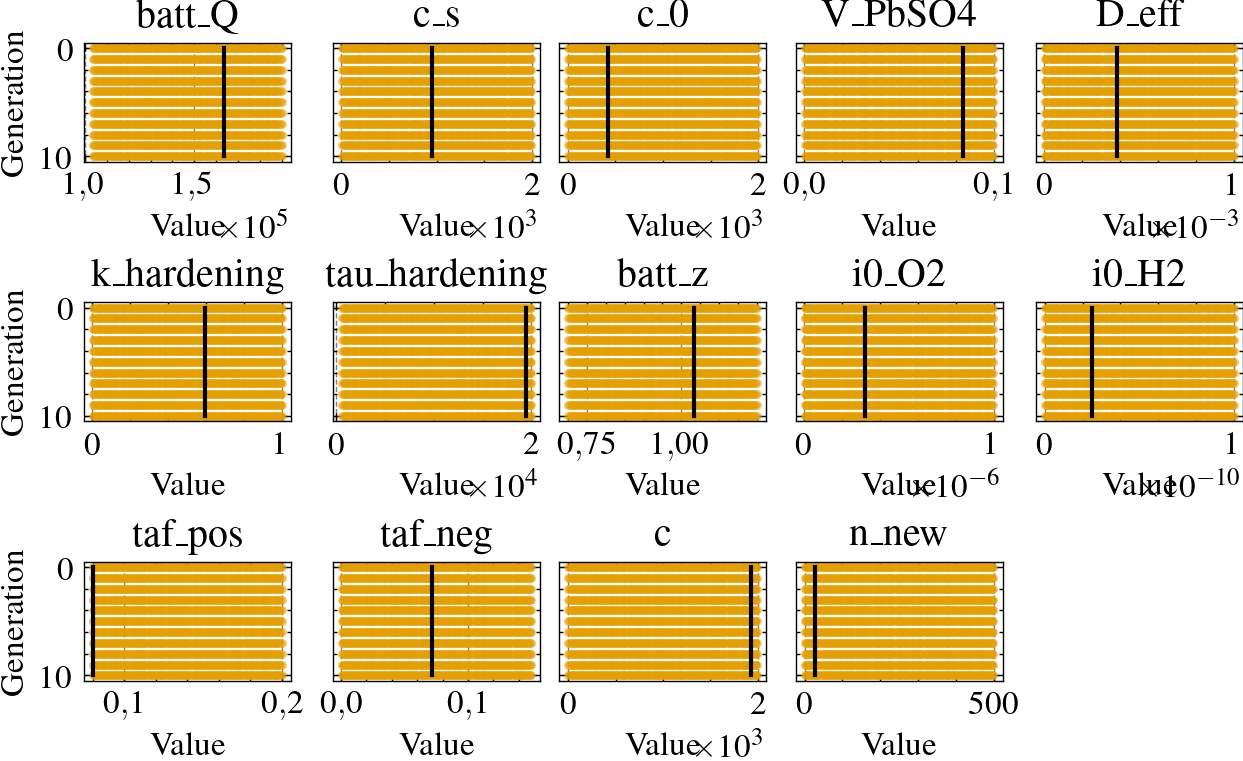

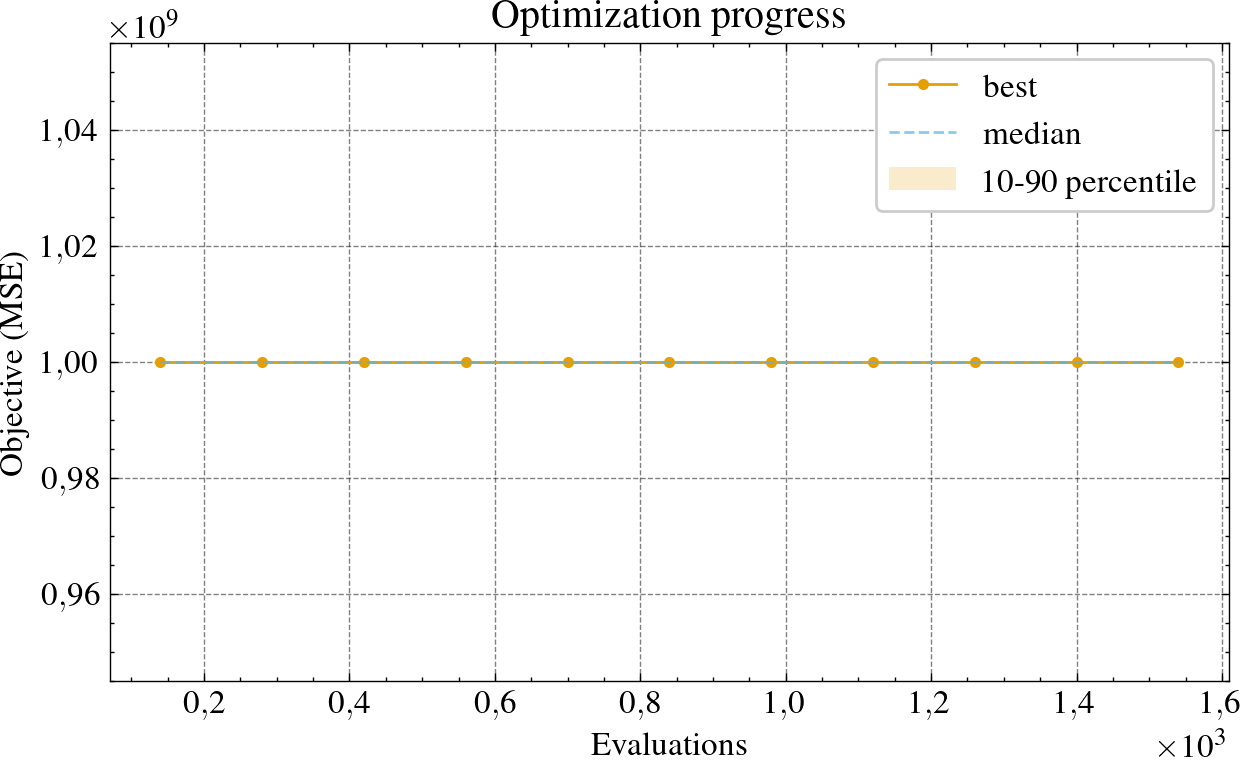

TypeError: model_function() got multiple values for argument 'T'

In [ ]:
%%time

def build_ECM_constraints(params_bounds: dict, eps = 0.003) -> list[ParamConstraint]:
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    return cons

model_params_D = initial_params.copy()
initial_SOC_D = 1
params_bounds_D = dict(
    # ------------------------------------------------------------
    # Fundamental battery-scale parameters
    # ------------------------------------------------------------
    batt_Q = dict(min=0.60*batt_Q, max=1.10*batt_Q), # multiplier × nominal_Q [As]

    # ------------------------------------------------------------
    # Electrolyte / PbSO4 overcharge model
    # ------------------------------------------------------------

    # Pb²⁺ equilibrium concentration range (paper: ~10⁻⁶–10⁻³ mol/cm³ → 1–1000 mol/m³)
    c_s = dict(min=1.0,      max=2000.0),        # [mol/m³]

    # Reference c₀ usually equals c_s, but we bound separately for fitting
    c_0 = dict(min=1.0,      max=2000.0),        # [mol/m³]

    # PbSO₄ volume fraction (0 at 100% SoC, up to ~0.1 at deep SoC)
    V_PbSO4 = dict(min=0.0,  max=0.10),          # [m³/m³]

    # Effective dissolution parameter (Thele 2006 fit range 10⁻⁶–10⁻⁴ s⁻¹)
    D_eff = dict(min=1e-7,   max=1e-3),          # [s⁻¹]

    # Hardening acceleration factor (no published value; based on observed effect)
    k_hardening = dict(min=0.0,   max=1.0),      # dimensionless multiplier

    # Crystal-aging time constant (minutes–hours scale)
    tau_hardening = dict(min=500.0,  max=20000.0),   # [s]

    # ------------------------------------------------------------
    # SoC state
    # ------------------------------------------------------------
    batt_z = dict(min=0.7, max=1.20),      # allow mild overshoot during fitting

    # ------------------------------------------------------------
    # Optional bounds for initial concentration states
    # ------------------------------------------------------------
    c = dict(min=1.0,  max=2000.0),    # mol/m³
    n_new  = dict(min=0.0,  max=500.0),     # no published values; low bound at 0
)

# Train w/ normal region
result_D, params_bounds_D, best_params_D, ending_SOC_D = run_battery_optimization(
    model=Battery,
    model_params=model_params_D,
    initial_SOC=initial_SOC_D,
    section_name='Section D',
    df=df,
    params_bounds=params_bounds_D,
    constraint_funcs=build_ECM_constraints(params_bounds_D),
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=10,
)

check_fit(model_params=model_params_D | best_params_D)

In [24]:
potato

NameError: name 'potato' is not defined